## ResNet Constructor.
Данный ноутбук содержит контруктор ResNet подобных сетей и пайплайн для работы с ним.
- accuracy на тестовой части датасета Imagenette составляет ###
- в pipeline'e реализовано сохранения метрик и модели 

### Oсновые блоки
[Загрузка датасета](#Загрузка-датасета) <br>
[Гиперпараметры обучения](#Гиперпараметры-обучения) <br>
[Просмотр датасета](#Просмотр-датасета) <br>
[Конструктор ResNet подобных сетей](#Конструктор-ResNet-подобных-сетей) <br>
[Инициализация модели](#Инициализация-модели) <br>
[Тренировочный цикл](#Тренировочный-цикл) <br>
[Проверка модели](#Проверка-модели) <br>
[Критика](#Критика)

In [1]:
import time
import warnings
import os

import numpy as np
import pandas as pd
import torch
from torchvision import transforms, datasets, utils
from fastai.vision.all import untar_data, URLs

from modules import datasets_loader, train_tools

warnings.filterwarnings('ignore')

### Загрузка датасета

In [2]:
# dataset_path = untar_data(URLs.IMAGENETTE_320, dest='../imagenette/')
# print(f'Imagenette dataset save to: {dataset_path}')

- eсли нужно установить fastai, то можете использовать команду <br>
'conda install -c fastai -c pytorch fastai'

### Гиперпараметры обучения

In [3]:
batch_size = 32
num_epoch = 360
learning_rate = 0.0007
optimizer_type = 'Adam'
save_best_model = True

# resnet architecture
resnet_layers = [3,4,6,3]
bottleneck = True
num_classes = 10

# learning_rate_decay
scheduler_type = 'cos'
cosine_cycles = 2
decay_steps = 5

dataset_path = '../imagenette/imagenette2-320/'
save_model_dir = './models/'
metrics_dir = './metrics/'

- batch_size: кол-во изображений в одном батче. Предел зависит от кол-ва памяти на видеокарте
- num_epoch: кол-во эпох обучения.
- learning_rate: скорость обучения.
- optimizer_type: тип оптимизатора, использующегося для обновления весов сети. Может быть 'SGD' или 'Adam'

<b>Архитектура сети:
 - layers - список с количеством стандартных блоков по слоям
 - num_classes - количество классов
 - bottleneck - определяет использование стандартных блоков или 'bottleneck' блоков <br>

(!) Конструктор ожидает на вход изображение с разрешением 224х224х3

Примеры стандартных сетей:<br>
<b>ResNet-18: </b> <br> 
model = ResNet_like(layers=[2,2,2,2], bottleneck=False, num_classes=10)

<b>ResNet-34: </b> <br> 
model = ResNet_like(resnet_layers=[3,4,6,3], bottleneck=False, num_classes=10)

<b>ResNet-50: </b> <br> 
model = ResNet_like(resnet_layers=[3,4,6,3], bottleneck=True, num_classes=10)

<b>ResNet-101: </b> <br> 
model = ResNet_like(resnet_layers=[3,4,23,3], bottleneck=True, num_classes=10)

<b>ResNet-152: </b> <br> 
model = ResNet_like(resnet_layers=[3,8,36,3], bottleneck=True, num_classes=10)
    
<b>Настройка изменения learning rate в течении обучения. </b><br> 
Реализовано две стратегии 'cos' - согласно функции косинуса и 'step' - ступенчатое уменьшение в 10 раз через равные промежутки.
- sheduler_type: задает стратегию изменения скорости обучения в течении обучения. может быть 'cos' или 'step'
- cosine_cycles: задает кол-во циклов изменения learning rate при косинусном уменьшении. Должно быть меньше или равно num_epoch.<br> 
- decay_steps: количество шагов уменьшения learning rate при ступенчатом уменьшении ('step'). Должно быть меньше или равно num_epoch.<br> 

Прочее
- dataset_path: путь к папке с датасетом.
- save_model_dir: путь к папке, в которую сохраняются модели.
- metrics_dir: путь к папке, в которую сохраняется файл с метриками обучения.
------------

Задаем название модели, которое будет фигурировать в названии сохраненных файлов метрики и модели<br>
Название модели является производным от гиперпараметров

In [4]:
m = 3 if bottleneck else 2
n = cosine_cycles if scheduler_type == 'cos' else decay_steps
model_name = f'ResNetD{sum(resnet_layers)*m + 2}_{optimizer_type}_lr{learning_rate}_b{batch_size}_{scheduler_type}_sc{(num_epoch-5)//n}'
print(f'model name is {model_name}')

model name is ResNetD50_Adam_lr0.0007_b32_cos_sc177


### Просмотр датасета

Посмотрим csv, приложенный к датасету

In [5]:
labels_df = pd.read_csv(dataset_path + '/noisy_imagenette.csv')
labels_df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


В приложенном датасете указаны пути к картинкам и их лейблы. <br>
Цифра после noisy_labels_ означает уровень зашумленности правильных ответов, т.е. noisy_labels_25 означает, что 25% правильных ответов - неправильные.

В этом ноутбуке мы будем работать без зашумления правильных ответов, т.е. нас интересует колонка 'noisy_labels_0'. <br>
Давайте посмотрим сколько уникальных классов находится в этом датасете.

In [6]:
print('Unique labels in Imagenette is', len(labels_df['noisy_labels_0'].unique()))

Unique labels in Imagenette is 10


Кол-во картинок в тренировочном датасете

In [7]:
train_img_qty = len(labels_df[labels_df['is_valid'] == False].index)
print(f'Image in train dataset: {train_img_qty}')

Image in train dataset: 9469


Кол-во картинок в тестовом датасете

In [8]:
test_img_qty = len(labels_df[labels_df['is_valid'] == True].index)
print(f'Image in test dataset: {test_img_qty}')

Image in test dataset: 3925


Давайте глянем на примеры картинок в тренировочном датасете

church


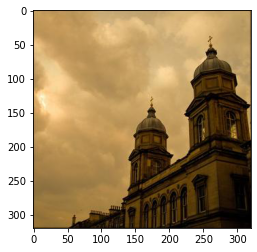

English springer


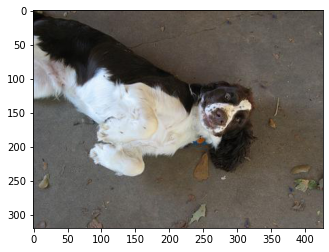

gas pump


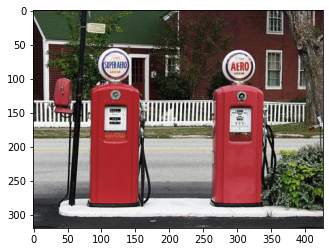

golf ball


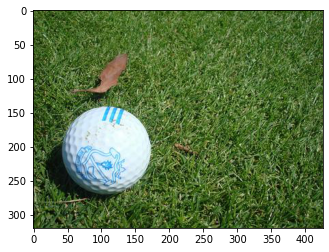

In [9]:
show_subset = datasets.ImageFolder(root=dataset_path + '/train/', transform=transforms.Compose([transforms.ToTensor()]))
show_subset = torch.utils.data.Subset(show_subset, np.random.randint(0,high=len(show_subset), size=4))
show_subset_loader = torch.utils.data.DataLoader(show_subset, shuffle=False)
for images, labels in show_subset_loader:
    print(datasets_loader.label_func(int(labels)))
    datasets_loader.visual_tensor(utils.make_grid(images))

### Создаем DataLoader попутно предобрабатывая данные

В качетсве аугментаций ипользуется:
- уменьшение картинки до разрешения 260*260
- вырезка случайного квадрата размером 224*224 (сеть ожидает именно эту размерность)
- переворот изображения по горизонтальной оси
- нормализация

In [10]:
train_transform = transforms.Compose([
        transforms.Resize((260,260)),
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

torch.set_num_threads(8)
trainset = datasets.ImageFolder(root=dataset_path + '/train/', transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.ImageFolder(root=dataset_path + '/val/', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False)

## Конструктор ResNet подобных сетей

(!) Конструктор ожидает на вход изображение с разрешением 224х224х3<br>

In [11]:
ResNet_A_Block

## Инициализация модели

Задаем оптимизаторы и создаем планировщик убывания скорости обучения

In [12]:
model = CNN_constructors.ResNet_like(layers=resnet_layers, bottleneck=bottleneck, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = train_tools.get_optimizer(model, optimizer_type, learning_rate)
scheduler = train_tools.get_scheduler(optimizer, scheduler_type, step_len=num_epoch//decay_steps, cycle_len=num_epoch//cosine_cycles)

In [13]:
type(scheduler)

torch.optim.lr_scheduler.CosineAnnealingWarmRestarts

Загружаем модель на видеокарту.

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


Создадим папки для сохранения моделей и метрик

In [15]:
datasets_loader.create_dir(save_model_dir)
datasets_loader.create_dir(metrics_dir)

already created
already created


Создаем датафрейм для записи метрик обучения. <br>
Датафрейм сохраняется в папку './metrics'

In [16]:
cols_name = ['epoch', 'time', 'current_lr', 'loss', 'accuracy_train', 'accuracy_val']
metrics_frame = pd.DataFrame(columns=cols_name)
metrics_frame_file = (metrics_dir + model_name + '.csv')
print(f'File with train metrics save to {metrics_frame_file}')

File with train metrics save to ./metrics/ResNetD50_Adam_lr0.0007_b32_cos_sc177.csv


## Тренировочный цикл

    - Основная метрика accuracy (топ1).
    - Метрика сохраняется в словарь и из словаря сохраняется в датасет и выводится на экран.
    - Лучшая мадель согласно валидации сохраняется на диск.

In [17]:
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # train cycle
    model.train()
    start_time = time.time()
    for data in trainloader:
        loss, outputs = train_tools.make_step(data, optimizer, model, criterion, device)
    scheduler.step()
    
    # metrics calc
    model.eval()
    accuracy_train = train_tools.approx_accuracy(trainset, model, device, denominator=16)
    accuracy_val = train_tools.approx_accuracy(testset, model, device, denominator=4)
    
    if accuracy_val >= .88 and accuracy_val >= metrics_frame['accuracy_val'].max():
        accuracy_val = train_tools.true_accuracy(testloader, model, device)

    end_time = time.time()
    metrics = {'epoch': epoch+1,
               'time': end_time - start_time,
               'current_lr': [group['lr'] for group in optimizer.param_groups][0],
               'loss': float(loss),
               'accuracy_train': accuracy_train,
               'accuracy_val': accuracy_val,
               }

    print("Epoch {}/{}, Time: {:.2f} sec, current_lr: {:.2e}, Loss: {:.3f}, Accuracy_train: {:.3f}, Accuracy_val: {:.3f}".
          format(metrics['epoch'], num_epoch, metrics['time'], metrics['current_lr'], metrics['loss'], metrics['accuracy_train'], metrics['accuracy_val']))
    
    metrics_frame = metrics_frame.append(pd.DataFrame.from_dict(metrics,orient='index').T)
    metrics_frame.to_csv(metrics_frame_file,index=False)
    
    if save_best_model:
        if metrics['accuracy_val'] == metrics_frame['accuracy_val'].max():
            torch.save(model, save_model_dir + model_name + '.pt')
if not save_best_model:
    torch.save(model, save_model_dir + model_name + '.pt')

Epoch 1/360, Time: 84.26 sec, current_lr: 7.00e-04, Loss: 2.377, Accuracy_train: 0.367, Accuracy_val: 0.388
Epoch 2/360, Time: 82.79 sec, current_lr: 7.00e-04, Loss: 1.604, Accuracy_train: 0.458, Accuracy_val: 0.429
Epoch 3/360, Time: 83.15 sec, current_lr: 7.00e-04, Loss: 1.205, Accuracy_train: 0.498, Accuracy_val: 0.520
Epoch 4/360, Time: 82.48 sec, current_lr: 6.99e-04, Loss: 1.620, Accuracy_train: 0.497, Accuracy_val: 0.529


KeyboardInterrupt: 

### Проверка модели

Посмотрим сохраненные в процессе обучения метрики

In [18]:
metrics_frame.tail()

,epoch,time,current_lr,loss,accuracy_train,accuracy_val
0,1.0,84.261363,0.000700,2.376506,0.366554,0.388379
0,2.0,82.786010,0.000700,1.604283,0.457770,0.429154
0,3.0,83.148533,0.000700,1.204808,0.498311,0.519878
0,4.0,82.481172,0.000699,1.620462,0.496622,0.529052


Посмотрим лучший результат на валидации

In [19]:
metrics_frame[metrics_frame['accuracy_val'] == metrics_frame['accuracy_val'].max()]

,epoch,time,current_lr,loss,accuracy_train,accuracy_val
0,4.0,82.481172,0.000699,1.620462,0.496622,0.529052


Проверяем сохраненную модель на соответствие метрикам в процессе обучения.

In [20]:
model = torch.load(save_model_dir + model_name + '.pt')
model = model.eval()

In [21]:
accuracy_check = train_tools.true_accuracy(testloader, model, device)

print(f'Accuracy saved model on the validation dataset is: {accuracy_check:.3f}')

Accuracy saved model on the validation dataset is: 0.526


### Критика

Известные проблемы:
- результат очень сильно зависит от стартового learning_rate. learning_rate для используемых оптимизаторов нужно выбирать в разном диапазоне (0,01-0,1 для SGD и 0,0001-0,01 для Adam), что приводит к некоторой путанице
- результат ниже baseline от fastai на 3 пункта
- датасет imagenette недостаточно большой, чтобы раскрыть возможности контруктора. Лучший результат получается с помощью ResNet-18 и ResNet-34
- метрика, посчитанная при проверке модели может отличаться от сохраненной в процессе обучения. <br>
Это происходит если в процессе обучения метрика считается только с помощью approx_accuracy()